<a href="https://colab.research.google.com/github/FranciscoConcha/FCC-Proyecto3/blob/main/Testeo_v1_0_qsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit-machine-learning scikit-learn
!pip install qiskit qiskit-aer qiskit-algorithms qiskit-machine-learning scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 17.9 MB/s eta 0:00:00


Generando dataset Ad Hoc...
Configurando Kernel Cuántico con Primitivas V2...
Entrenando SVMs...

--- Resultados de Precisión ---
Quantum SVM:  1.00
Classical SVM: 0.35
Generando visualización...


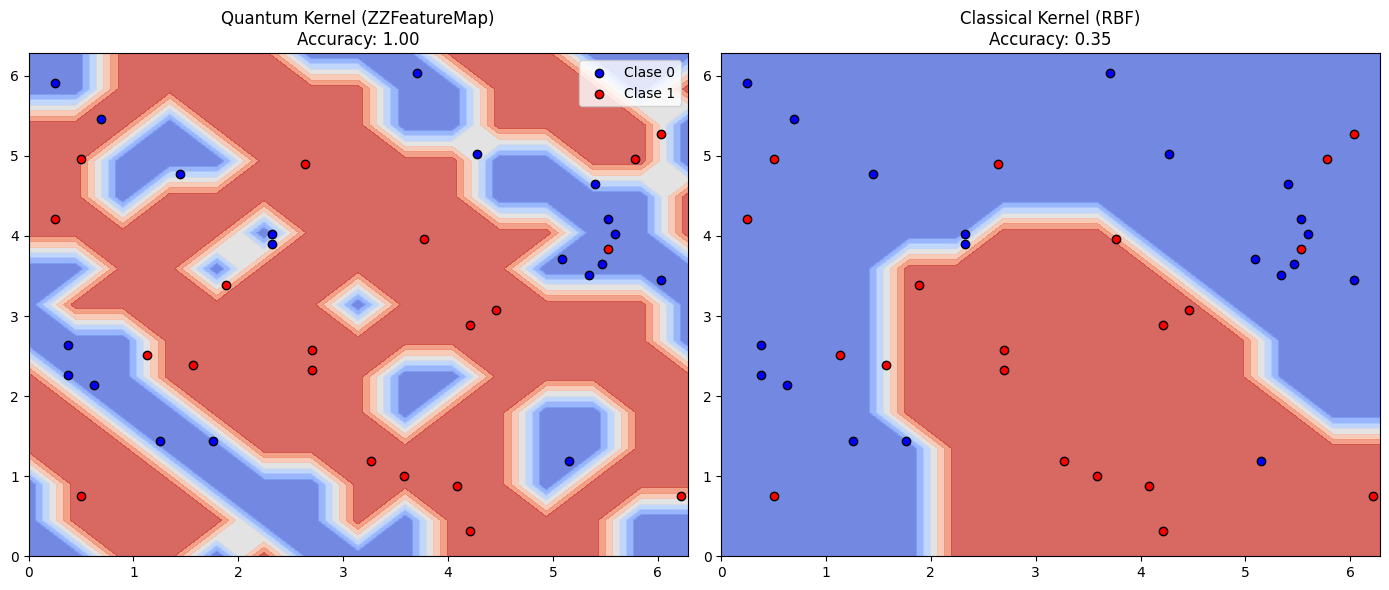

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Librerías de Machine Learning Clásico
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Librerías de Qiskit
from qiskit.circuit.library import ZZFeatureMap
# --- CORRECCIÓN AQUÍ: Importamos el Sampler V2 ---
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

# ==========================================
# 1. Configuración y Generación de Datos
# ==========================================
print("Generando dataset Ad Hoc...")
feature_dim = 2
train_features, train_labels, test_features, test_labels = ad_hoc_data(
    training_size=20,
    test_size=10,
    n=feature_dim,
    gap=0.3,
    plot_data=False
)

# Aplanamos etiquetas
y_train = np.argmax(train_labels, axis=1)
y_test = np.argmax(test_labels, axis=1)

# ==========================================
# 2. Definición del Kernel Cuántico (V2)
# ==========================================
print("Configurando Kernel Cuántico con Primitivas V2...")
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

# --- CORRECCIÓN AQUÍ: Usamos StatevectorSampler (V2) ---
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)

# Creamos el objeto Kernel
q_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# ==========================================
# 3. Entrenamiento de Modelos
# ==========================================
print("Entrenando SVMs...")

# A) Quantum SVM (QSVC)
qsvc = SVC(kernel=q_kernel.evaluate)
qsvc.fit(train_features, y_train)
q_score = qsvc.score(test_features, y_test)

# B) SVM Clásico (RBF)
csvc = SVC(kernel="rbf", gamma="scale")
csvc.fit(train_features, y_train)
c_score = csvc.score(test_features, y_test)

print(f"\n--- Resultados de Precisión ---")
print(f"Quantum SVM:  {q_score:.2f}")
print(f"Classical SVM: {c_score:.2f}")

# ==========================================
# 4. Visualización (Gráfica)
# ==========================================
print("Generando visualización...")

resolution = 15
xx, yy = np.meshgrid(
    np.linspace(0, 2 * np.pi, resolution),
    np.linspace(0, 2 * np.pi, resolution)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grid para predecir
grid_points = np.c_[xx.ravel(), yy.ravel()]

# --- Gráfico 1: Quantum SVM ---
Z_q = qsvc.predict(grid_points)
Z_q = Z_q.reshape(xx.shape)

ax1.contourf(xx, yy, Z_q, cmap=plt.cm.coolwarm, alpha=0.8)
ax1.scatter(train_features[y_train==0, 0], train_features[y_train==0, 1], c='b', edgecolors='k', label="Clase 0")
ax1.scatter(train_features[y_train==1, 0], train_features[y_train==1, 1], c='r', edgecolors='k', label="Clase 1")
ax1.set_title(f"Quantum Kernel (ZZFeatureMap)\nAccuracy: {q_score:.2f}")
ax1.legend()

# --- Gráfico 2: Classical SVM ---
Z_c = csvc.predict(grid_points)
Z_c = Z_c.reshape(xx.shape)

ax2.contourf(xx, yy, Z_c, cmap=plt.cm.coolwarm, alpha=0.8)
ax2.scatter(train_features[y_train==0, 0], train_features[y_train==0, 1], c='b', edgecolors='k')
ax2.scatter(train_features[y_train==1, 0], train_features[y_train==1, 1], c='r', edgecolors='k')
ax2.set_title(f"Classical Kernel (RBF)\nAccuracy: {c_score:.2f}")

plt.tight_layout()
plt.show()